<a href="https://colab.research.google.com/github/hoangnam-nguyen/sms_text_classification/blob/main/fcc_sms_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

You should create a function called `predict_message` that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, you will use the [SMS Spam Collection dataset](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.


In [1]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

     |████████████████████████████████| 467.9 MB 25 kB/s 
     |████████████████████████████████| 1.3 MB 38.5 MB/s 
     |████████████████████████████████| 5.7 MB 41.6 MB/s 
     |████████████████████████████████| 463 kB 36.4 MB/s 
     |████████████████████████████████| 2.3 MB 38.6 MB/s 
     |████████████████████████████████| 12.8 MB 151 kB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires flatbuffers~=1.12.0, but you have flatbuffers 2.0 which is incompatible.
2.7.0-dev20210829


In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2021-08-30 04:10:38--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.04s   

2021-08-30 04:10:38 (8.81 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2021-08-30 04:10:38--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==========

### Read contents of files

In [3]:
txt_train = open(train_file_path, 'rb').read().decode(encoding='utf-8')
txt_test = open(test_file_path, 'rb').read().decode(encoding='utf-8')

### Assess the datasets

Number of characters in each file

In [4]:
print('Length of training dataset text: {} characters'.format(len(txt_train)))
print('Length of test dataset text: {} characters'.format(len(txt_test)))

Length of training dataset text: 357755 characters
Length of test dataset text: 118550 characters


How the txt_train looks like

In [5]:
txt_train[:500]

'ham\tahhhh...just woken up!had a bad dream about u tho,so i dont like u right now :) i didnt know anything about comedy night but i guess im up for it.\nham\tyou can never do nothing\nham\tnow u sound like manky scouse boy steve,like! i is travelling on da bus home.wot has u inmind 4 recreation dis eve?\nham\tmum say we wan to go then go... then she can shun bian watch da glass exhibition...\nham\tnever y lei... i v lazy... got wat? dat day ü send me da url cant work one...\nham\tin xam hall boy asked girl'

###Process the data

In [6]:
txt_train = txt_train.split('\n')
txt_test = txt_test.split('\n')
print(len(txt_train))
print(len(txt_test))

4180
1393


Remove empty item in both lists

In [7]:
txt_train = [x for x in txt_train if x != '']
txt_test = [x for x in txt_test if x != '']
print(len(txt_train))
print(len(txt_test))

4179
1392


Build training and test datasets (features and labels)

In [8]:
# Clean text and then one-hot-encode
import string
from nltk.stem.porter import PorterStemmer
from collections import Counter
from keras.preprocessing.text import one_hot
train_features = []
test_features = []
train_labels = []
test_labels = []

vocab_size = 100

for line in txt_train:
  # Break each line into words
  token = line.split('\t')[1].split()
  # Remove remaining tokes that are not alphabetic
  words = [w for w in token if w.isalpha()]
  # Stemming of words
  porter = PorterStemmer()
  stemmed = [porter.stem(w) for w in words]
  feature = ' '.join(stemmed)
  # One-hot-encoding
  train_labels.append(line.split('\t')[0])
  train_features.append(one_hot(feature, vocab_size))
  
for line in txt_test:
  # Break each line into words
  token = line.split('\t')[1].split()
  # Remove remaining tokes that are not alphabetic
  words = [w for w in token if w.isalpha()]
  # Stemming of words
  porter = PorterStemmer()
  stemmed = [porter.stem(w) for w in words]
  feature = ' '.join(stemmed)
  # One-hot-encoding
  test_labels.append(line.split('\t')[0])
  test_features.append(one_hot(feature, vocab_size))

print(Counter(train_labels))
print(Counter(test_labels))

Counter({'ham': 3619, 'spam': 560})
Counter({'ham': 1205, 'spam': 187})


In [9]:
print(train_features[0])
print(test_features[0])

[60, 90, 77, 81, 81, 50, 37, 15, 52, 50, 1, 71, 37, 26, 70, 61, 81, 54, 22, 54, 37, 4, 96, 87, 75]
[37, 44, 67, 50, 37, 75, 70, 56, 67, 41]


In [10]:
train_labels = np.array([1 if label=='spam' else 0 for label in train_labels])
test_labels = np.array([1 if label=='spam' else 0 for label in test_labels])

Pad document to a max length of 150 (estimated from train_features)

In [11]:
from keras.preprocessing.sequence import pad_sequences

max_length = 100
train_padded = pad_sequences(train_features, maxlen=max_length)
test_padded = pad_sequences(test_features, maxlen=max_length)
print(train_padded[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0 60 90 77 81 81 50 37 15 52 50  1 71 37 26 70 61 81 54 22 54 37
  4 96 87 75]


###Build the model

Define model

In [12]:
epochs = 10

model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, 64),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(256, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          6400      
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 56,321
Trainable params: 56,321
Non-trainable params: 0
_________________________________________________________________


Compile model

In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Train model

In [14]:
history = model.fit(train_padded, train_labels, epochs=epochs, batch_size=128, validation_data=(test_padded, test_labels))

Epoch 1/10
33/33 [==============================] - 16s 354ms/step - loss: 0.4428 - accuracy: 0.8574 - val_loss: 0.3062 - val_accuracy: 0.8657
Epoch 2/10
33/33 [==============================] - 6s 195ms/step - loss: 0.2300 - accuracy: 0.9031 - val_loss: 0.1638 - val_accuracy: 0.9432
Epoch 3/10
33/33 [==============================] - 6s 196ms/step - loss: 0.1513 - accuracy: 0.9500 - val_loss: 0.1436 - val_accuracy: 0.9490
Epoch 4/10
33/33 [==============================] - 6s 194ms/step - loss: 0.1342 - accuracy: 0.9541 - val_loss: 0.1397 - val_accuracy: 0.9497
Epoch 5/10
33/33 [==============================] - 6s 194ms/step - loss: 0.1276 - accuracy: 0.9569 - val_loss: 0.1372 - val_accuracy: 0.9526
Epoch 6/10
33/33 [==============================] - 6s 194ms/step - loss: 0.1209 - accuracy: 0.9600 - val_loss: 0.1352 - val_accuracy: 0.9533
Epoch 7/10
33/33 [==============================] - 6s 195ms/step - loss: 0.1193 - accuracy: 0.9622 - val_loss: 0.1318 - val_accuracy: 0.9583
Epoch

Plotting accuracy

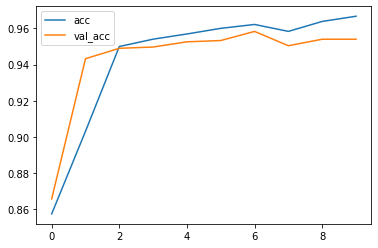

In [15]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

### Complete function to predict messages based on model

In [16]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):

  # Remove remaining tokes that are not alphabetic
  words = [w for w in pred_text.split() if w.isalpha()]
  # Stemming of words
  porter = PorterStemmer()
  stemmed = [porter.stem(w) for w in words]
  clean_text = ' '.join(stemmed)
  # Padding text and make prediction
  padded_text = pad_sequences([one_hot(clean_text, vocab_size)], maxlen=max_length)
  likeliness = model.predict(padded_text)[0][0]
  prediction = [likeliness, 'ham' if likeliness < 0.5 else 'spam']

  return (prediction)

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

[0.004643053, 'ham']


### Pass freeCodeCamp's test

In [17]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    print(prediction)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


[0.0024040043, 'ham']
[0.94479084, 'spam']
[0.0032589138, 'ham']
[0.9806099, 'spam']
[0.8246738, 'spam']
[0.0040956736, 'ham']
[0.04020077, 'ham']
You passed the challenge. Great job!
